# Depression Detection from Reddit Posts

# Step-by-Step Flow:

1)**Authenticate** Reddit API using credentials.

2)**Load existing data from CSV** — if not found, scrape Reddit (depression + control subreddits).

          If scraping fails → uses sample fallback data.

3)Explore dataset using **DataVisualizer**.

4)Initialize the **depression detection model**.

5)**Train and evaluate models** (Logistic Regression, Random Forest, SVM) with an 80–20 train–test split.

6)Visualize results (accuracy, F1, AUC, confusion matrices).

7)Analyze top important features (e.g., “hopeless”, “I”, “tired”).

8)Test model on sample texts and print depression probabilities + linguistic feature values.

9)Print best-performing model summary.

Return: model, results, and data.



## Installation and Setup
This cell installs all required packages and imports necessary libraries.

In [1]:

# Install required packages
!pip install textstat spacy matplotlib seaborn wordcloud
!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from textstat import flesch_reading_ease, syllable_count
from collections import Counter
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

print(" All libraries installed and imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 137.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...


 All libraries installed and imported successfully!


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# Data Loading and Exploration Class
class DataLoader:
    """
    Load and explore the existing CSV dataset
    """

    @staticmethod
    def load_data(file_path):
        """
        Load the CSV file and explore its structure
        """
        print(f" Loading data from {file_path}...")

        # Load the CSV file
        df = pd.read_csv(file_path)

        print(" Data loaded successfully!")
        print(f" Dataset shape: {df.shape}")
        print("\n Column names:")
        for col in df.columns:
            print(f"   - {col}")

        # Check for missing values
        print("\n Missing values:")
        missing_data = df.isnull().sum()
        for col, missing_count in missing_data.items():
            if missing_count > 0:
                print(f"   - {col}: {missing_count} missing values")

        # Display basic info about the target variable
        if 'predicted_depression' in df.columns:
            print(f"\n Target variable 'predicted_depression' distribution:")
            target_counts = df['predicted_depression'].value_counts()
            print(target_counts)

            # Calculate percentages
            total = len(df)
            print(f"\n Class percentages:")
            for value, count in target_counts.items():
                percentage = (count / total) * 100
                print(f"   - Class {value}: {count} samples ({percentage:.2f}%)")

        return df

    @staticmethod
    def prepare_data(df, text_columns=['text', 'title']):
        """
        Prepare the data for modeling by combining text columns and handling target variable
        """
        # Create a copy to avoid modifying original data
        data = df.copy()

        # Use predicted_depression as the target variable
        if 'predicted_depression' in data.columns:
            print(" Using 'predicted_depression' column as target variable")
            data['is_depression'] = data['predicted_depression']

            # Ensure it's numeric and handle any non-numeric values
            data['is_depression'] = pd.to_numeric(data['is_depression'], errors='coerce')

            # Drop rows with NaN in target
            original_len = len(data)
            data = data.dropna(subset=['is_depression'])
            if len(data) < original_len:
                print(f"  Dropped {original_len - len(data)} rows with invalid target values")

            # Convert to integer
            data['is_depression'] = data['is_depression'].astype(int)

            print(f" Target variable prepared: {data['is_depression'].value_counts().to_dict()}")

        # Combine text columns for analysis
        print("\nPreparing text data...")
        data['combined_text'] = ""

        for col in text_columns:
            if col in data.columns:
                # Fill NaN with empty string and convert to string
                data[col] = data[col].fillna('').astype(str)
                # Add to combined text with space separation
                data['combined_text'] += data[col] + " "
                print(f"   - Using column: {col}")
            else:
                print(f"     Column not found: {col}")

        # Remove extra spaces
        data['combined_text'] = data['combined_text'].str.strip()

        # Check text length distribution
        data['text_length'] = data['combined_text'].str.len()
        print(f"   - Average text length: {data['text_length'].mean():.1f} characters")
        print(f"   - Min text length: {data['text_length'].min()} characters")
        print(f"   - Max text length: {data['text_length'].max()} characters")

        # Filter out very short texts
        original_len = len(data)
        data = data[data['text_length'] >= 10]  # At least 10 characters
        if len(data) < original_len:
            print(f"   - Filtered out {original_len - len(data)} very short texts")

        print(f" Final dataset size: {len(data)} samples")

        return data

## Text Preprocessor
This cell defines the text preprocessing class that handles cleaning and extracts linguistic features important for depression detection.

The AdvancedTextPreprocessor class is responsible for turning raw Reddit text into:

a cleaned, lemmatized version ready for TF-IDF or other text vectorization

a dictionary of linguistic/psychological features (ratios of pronoun use, emotional words, etc.)

## 1️) Initialization —
__init__()
## 2)Text cleaning —
clean_text(text)

## 3) Linguistic feature extraction —
extract_linguistic_features(text)

## 4)Tokenization and Lemmatization —
tokenize_and_lemmatize(text)
## 5)Full pipeline —
### preprocess_text(text, extract_features=True)

This combines everything into a complete preprocessing step:

Clean the text

Extract linguistic features (ratios, counts, etc.)

Tokenize + Lemmatize

Returns:

### processed_text → cleaned, lemmatized text (for TF-IDF input)

### linguistic_features → dictionary of numeric features

In [3]:
# Advanced Text Preprocessing Class
class AdvancedTextPreprocessor:
    """
    Advanced text preprocessing with linguistic feature extraction for depression detection.
    """

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        # Extended stop words specific to depression context
        self.extended_stop_words = self.stop_words.union({
            'like', 'get', 'would', 'could', 'really', 'much', 'even',
            'also', 'something', 'anything', 'everything', 'nothing',
            'know', 'think', 'feel', 'make', 'take', 'see', 'come', 'go'
        })

        # Load spaCy model for advanced NLP
        try:
            self.nlp = spacy.load('en_core_web_sm')
            print(" spaCy model loaded successfully!")
        except:
            print(" Could not load spaCy model. Using fallback methods.")
            self.nlp = None

    def extract_linguistic_features(self, text):
        """
        Extract sophisticated linguistic features indicative of depression
        """
        features = {}

        if self.nlp:
            # Use spaCy for advanced analysis
            doc = self.nlp(text)

            # Basic text statistics
            words = [token.text for token in doc if token.is_alpha]
            sentences = list(doc.sents)

            total_words = len(words)
            total_sentences = len(sentences)

            if total_words == 0:
                # Return default values for empty text
                return self._get_default_features()

            # 1. PRONOUN ANALYSIS (Key depression indicator)
            pronouns = Counter([token.lemma_.lower() for token in doc if token.pos_ == 'PRON'])

            # First person singular (I, me, my, mine) - HIGH in depression
            first_singular = sum(pronouns.get(pronoun, 0) for pronoun in ['i', 'me', 'my', 'mine'])
            features['first_person_singular_ratio'] = first_singular / total_words

            # First person plural (we, us, our, ours) - LOW in depression
            first_plural = sum(pronouns.get(pronoun, 0) for pronoun in ['we', 'us', 'our', 'ours'])
            features['first_person_plural_ratio'] = first_plural / total_words

            # Second person (you, your, yours)
            second_person = sum(pronouns.get(pronoun, 0) for pronoun in ['you', 'your', 'yours'])
            features['second_person_ratio'] = second_person / total_words

            # 2. VERB TENSE ANALYSIS (Past focus in depression)
            past_tense = len([token for token in doc if token.tag_ in ['VBD', 'VBN']])  # Past tense verbs
            present_tense = len([token for token in doc if token.tag_ in ['VB', 'VBP', 'VBZ']])  # Present tense

            total_verbs = past_tense + present_tense
            features['past_tense_ratio'] = past_tense / total_verbs if total_verbs > 0 else 0

            # 3. NEGATION AND NEGATIVE WORDS
            negation_words = ['no', 'not', 'never', 'nothing', 'none', 'nobody', 'nowhere',
                            'neither', 'nor', 'cannot', "can't", "won't", "don't", "isn't"]
            negation_count = len([token for token in doc if token.text.lower() in negation_words])
            features['negation_ratio'] = negation_count / total_words

            # 4. EMOTIONAL WORD ANALYSIS
            # Depression-related emotional words (expanded list)
            depression_emotional_words = {
                'sad', 'empty', 'hopeless', 'worthless', 'guilty', 'anxious', 'angry',
                'lonely', 'tired', 'exhausted', 'numb', 'miserable', 'depressed',
                'anxiety', 'panic', 'fear', 'scared', 'worry', 'worried', 'dread',
                'suicide', 'suicidal', 'death', 'die', 'kill', 'pain', 'suffering'
            }

            emotional_count = len([token for token in doc if token.lemma_.lower() in depression_emotional_words])
            features['emotional_word_ratio'] = emotional_count / total_words

            # 5. READABILITY AND COMPLEXITY
            features['readability'] = flesch_reading_ease(text)
            features['word_count'] = total_words
            features['sentence_count'] = total_sentences
            features['avg_sentence_length'] = total_words / total_sentences if total_sentences > 0 else 0
            features['avg_word_length'] = np.mean([len(word) for word in words]) if words else 0

            # 6. MODAL VERBS (would, could, should - indecisiveness)
            modal_verbs = ['would', 'could', 'should', 'might', 'may']
            modal_count = len([token for token in doc if token.lemma_.lower() in modal_verbs])
            features['modal_verb_ratio'] = modal_count / total_words

            # 7. QUESTION USAGE
            question_marks = text.count('?')
            features['question_ratio'] = question_marks / total_sentences if total_sentences > 0 else 0

        else:
            # Fallback without spaCy
            features = self._extract_basic_features(text)

        return features

    def _get_default_features(self):
        """Return default feature values for empty text"""
        return {
            'first_person_singular_ratio': 0,
            'first_person_plural_ratio': 0,
            'second_person_ratio': 0,
            'past_tense_ratio': 0,
            'negation_ratio': 0,
            'emotional_word_ratio': 0,
            'readability': 0,
            'word_count': 0,
            'sentence_count': 0,
            'avg_sentence_length': 0,
            'avg_word_length': 0,
            'modal_verb_ratio': 0,
            'question_ratio': 0
        }

    def _extract_basic_features(self, text):
        """Basic feature extraction without spaCy"""
        # Simplified implementation
        words = text.split()
        total_words = len(words)

        if total_words == 0:
            return self._get_default_features()

        features = {}

        # Basic pronoun counting
        features['first_person_singular_ratio'] = sum(1 for word in words if word.lower() in ['i', 'me', 'my', 'mine']) / total_words
        features['negation_ratio'] = sum(1 for word in words if word.lower() in ['no', 'not', 'never']) / total_words
        features['word_count'] = total_words

        return features

    def clean_text(self, text):
        """
        Comprehensive text cleaning for Reddit posts
        """
        if not isinstance(text, str):
            return ""

        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove Reddit-specific formatting
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'\(.*?\)', '', text)
        # Remove special characters but keep basic punctuation
        text = re.sub(r'[^\w\s\.\!\?]', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_and_lemmatize(self, text):
        """
        Advanced tokenization with POS-aware lemmatization
        """
        if self.nlp:
            doc = self.nlp(text)
            tokens = []

            for token in doc:
                if (token.is_alpha and
                    not token.is_stop and
                    len(token.text) > 2 and
                    token.text.lower() not in self.extended_stop_words):

                    # Use POS tag for better lemmatization
                    if token.pos_ == 'VERB':
                        lemma = self.lemmatizer.lemmatize(token.text, pos='v')
                    else:
                        lemma = self.lemmatizer.lemmatize(token.text)
                    tokens.append(lemma.lower())

            return tokens
        else:
            # Fallback method
            words = word_tokenize(text)
            return [self.lemmatizer.lemmatize(word.lower()) for word in words
                   if word.isalpha() and word.lower() not in self.extended_stop_words and len(word) > 2]

    def preprocess_text(self, text, extract_features=True):
        """
        Complete text preprocessing pipeline
        """
        # Clean text
        cleaned_text = self.clean_text(text)

        # Extract linguistic features
        linguistic_features = {}
        if extract_features:
            linguistic_features = self.extract_linguistic_features(cleaned_text)

        # Tokenize and lemmatize for bag-of-words features
        tokens = self.tokenize_and_lemmatize(cleaned_text)
        processed_text = ' '.join(tokens)

        return processed_text, linguistic_features

# Feature Engineering
This cell combines TF-IDF features with linguistic features to create comprehensive text representations for machine learning.

## Why Combine Linguistic + TF-IDF?

### TF-IDF →
Captures what is said (the literal words, phrases, and their statistical importance).

### Linguistic features →
Capture how it’s said (psychological style, structure, and emotional cues).

### When combined, we get both:

Semantic information (topics, keywords), and

Psychological signal (tone, self-focus, emotion, cognitive load).

This combination tends to boost model performance in depression detection and other affective computing tasks.

## Why TF-IDF over simple counts:
 **Reduces common word dominance**: Words like "the", "and" get low weights

 **Highlights distinctive words**: Depression-related words get higher weights

 **Better for classification**: Emphasizes words that differentiate classes

 **Handles document length**: Normalizes for different text lengths

In [4]:
# Feature Engineering Class
class FeatureEngineer:
    """
    Feature engineering for depression detection combining:
    - TF-IDF features (word representations)
    - Linguistic features (psychological indicators)
    """

    def __init__(self):
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=3000,
            ngram_range=(1, 2),  # Unigrams and bigrams
            stop_words='english',
            min_df=2,           # Ignore terms that appear in less than 2 documents
            max_df=0.85,        # Ignore terms that appear in more than 85% of documents
            sublinear_tf=True   # Apply sublinear tf scaling
        )
        self.scaler = StandardScaler()
        self.is_fitted = False

    def prepare_features(self, texts, linguistic_features_list, fit_vectorizer=True):
        """
        Prepare combined features: TF-IDF + Linguistic features
        """
        # TF-IDF features
        if fit_vectorizer:
            tfidf_features = self.tfidf_vectorizer.fit_transform(texts)
            self.is_fitted = True
        else:
            if not self.is_fitted:
                raise ValueError("Vectorizer not fitted yet. Call with fit_vectorizer=True first.")
            tfidf_features = self.tfidf_vectorizer.transform(texts)

        # Linguistic features
        linguistic_array = np.array([list(features.values()) for features in linguistic_features_list])

        # Scale linguistic features
        if fit_vectorizer:
            linguistic_array = self.scaler.fit_transform(linguistic_array)
        else:
            linguistic_array = self.scaler.transform(linguistic_array)

        # Combine features
        combined_features = np.hstack([tfidf_features.toarray(), linguistic_array])

        print(f"🔧 Feature Engineering Complete:")
        print(f"   - TF-IDF features: {tfidf_features.shape[1]}")
        print(f"   - Linguistic features: {linguistic_array.shape[1]}")
        print(f"   - Total features: {combined_features.shape[1]}")

        return combined_features

    def get_feature_names(self):
        """Get names of all features"""
        if not self.is_fitted:
            return []

        tfidf_names = list(self.tfidf_vectorizer.get_feature_names_out())
        linguistic_names = ['first_person_singular', 'first_person_plural', 'second_person',
                          'past_tense', 'negation', 'emotional_words', 'readability',
                          'word_count', 'sentence_count', 'avg_sentence_len',
                          'avg_word_len', 'modal_verbs', 'questions']

        return tfidf_names + linguistic_names

## **Depression** Detection Model
This cell defines the main model class that implements multiple machine learning algorithms and handles training/evaluation.

### **DepressionDetectionModel** is a wrapper class that:

integrates our preprocessing (AdvancedTextPreprocessor)

integrates our feature engineering (FeatureEngineer)

defines and trains multiple ML classifiers

evaluates, visualizes, and interprets their performance

can make predictions on new text

It’s the top-level “manager” that ties your entire pipeline together.

In [5]:
# Depression Detection Model Class
class DepressionDetectionModel:
    """
    Main depression detection model with multiple classifiers and comprehensive evaluation.
    """

    def __init__(self):
        self.models = {
            'logistic_regression': LogisticRegression(
                random_state=42,
                class_weight='balanced',  # Handle class imbalance
                max_iter=1000,
                C=0.1,  # Stronger regularization
                solver='liblinear'
            ),
            'random_forest': RandomForestClassifier(
                random_state=42,
                n_estimators=150,
                max_depth=20,
                min_samples_split=5,
                min_samples_leaf=2,
                class_weight='balanced',
                max_features='sqrt'
            ),
            'svm': SVC(
                random_state=42,
                class_weight='balanced',
                probability=True,
                kernel='rbf',
                C=1.0,
                gamma='scale'
            )
        }

        self.preprocessor = AdvancedTextPreprocessor()
        self.feature_engineer = FeatureEngineer()
        self.trained_models = {}
        self.results = {}

        print(" Depression Detection Model Initialized!")
        print("   Available models: Logistic Regression, Random Forest, SVM")

    def prepare_dataset(self, df, text_column='combined_text'):
        """
        Prepare the complete dataset for training
        """
        processed_texts = []
        linguistic_features_list = []

        print(" Preprocessing texts and extracting features...")

        for i, text in enumerate(df[text_column]):
            if i % 100 == 0:
                print(f"   Processed {i}/{len(df)} texts...")

            processed_text, linguistic_features = self.preprocessor.preprocess_text(text)
            processed_texts.append(processed_text)
            linguistic_features_list.append(linguistic_features)

        # Prepare features
        X = self.feature_engineer.prepare_features(processed_texts, linguistic_features_list, fit_vectorizer=True)
        y = df['is_depression'].values

        print(f" Dataset prepared: {X.shape[0]} samples, {X.shape[1]} features")

        return X, y, processed_texts, linguistic_features_list

    def train_and_evaluate(self, df, text_column='combined_text', test_size=0.2):
        """
        Complete training and evaluation pipeline
        """
        # Prepare data
        X, y, _, _ = self.prepare_dataset(df, text_column)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        print(f"\n Data Split:")
        print(f"   Training samples: {X_train.shape[0]}")
        print(f"   Testing samples: {X_test.shape[0]}")
        print(f"   Features: {X_train.shape[1]}")

        results = {}

        # Train and evaluate each model
        for model_name, model in self.models.items():
            print(f"\n Training {model_name.replace('_', ' ').title()}...")

            # Train model
            model.fit(X_train, y_train)
            self.trained_models[model_name] = model

            # Predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            auc_roc = roc_auc_score(y_test, y_pred_proba)

            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

            # Precision, Recall, F1
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

            # Store results
            results[model_name] = {
                'accuracy': accuracy,
                'auc_roc': auc_roc,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'classification_report': classification_report(y_test, y_pred),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'y_true': y_test,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

            print(f"    {model_name.replace('_', ' ').title()} Results:")
            print(f"      Accuracy: {accuracy:.4f}")
            print(f"      AUC-ROC: {auc_roc:.4f}")
            print(f"      Precision: {precision:.4f}")
            print(f"      Recall: {recall:.4f}")
            print(f"      F1-Score: {f1:.4f}")
            print(f"      CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")

        self.results = results
        return results

    def plot_results(self, results=None):
        """
        Create comprehensive visualization of model results
        """
        if results is None:
            results = self.results

        models = list(results.keys())
        model_names = [name.replace('_', ' ').title() for name in models]

        # Metrics to plot
        metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

        values = {metric: [results[model][metric] for model in models] for metric in metrics}

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Depression Detection Model Performance Comparison', fontsize=16, fontweight='bold')

        # Bar plot for main metrics
        x = np.arange(len(models))
        width = 0.15

        for i, metric in enumerate(metrics[:4]):
            row, col = i // 2, i % 2
            axes[row, col].bar(x + i*width, values[metric], width, label=metric_names[i], alpha=0.8)
            axes[row, col].set_title(f'{metric_names[i]} Comparison')
            axes[row, col].set_xlabel('Models')
            axes[row, col].set_ylabel(metric_names[i])
            axes[row, col].set_xticks(x + width*1.5)
            axes[row, col].set_xticklabels(model_names, rotation=45)
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)

            # Add value labels on bars
            for j, v in enumerate(values[metric]):
                axes[row, col].text(j + i*width, v + 0.01, f'{v:.3f}',
                                  ha='center', va='bottom', fontsize=9)

        # AUC-ROC comparison
        plt.figure(figsize=(10, 6))
        plt.bar(model_names, values['auc_roc'], color=['#ff9999', '#66b3ff', '#99ff99'], alpha=0.8)
        plt.title('AUC-ROC Score Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('AUC-ROC Score')
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)

        # Add value labels
        for i, v in enumerate(values['auc_roc']):
            plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Confusion matrices
        self.plot_confusion_matrices(results)

    def plot_confusion_matrices(self, results):
        """Plot confusion matrices for all models"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

        for i, (model_name, result) in enumerate(results.items()):
            cm = result['confusion_matrix']
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                       xticklabels=['Non-Depressed', 'Depressed'],
                       yticklabels=['Non-Depressed', 'Depressed'])
            axes[i].set_title(f'{model_name.replace("_", " ").title()}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

    def analyze_important_features(self, top_n=25):
        """
        Analyze and visualize most important features
        """
        if 'random_forest' not in self.trained_models:
            print(" Random Forest model not trained yet")
            return None

        rf_model = self.trained_models['random_forest']
        feature_importances = rf_model.feature_importances_

        # Get feature names
        feature_names = self.feature_engineer.get_feature_names()

        # Create feature importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importances
        }).sort_values('importance', ascending=False)

        print(f"\n🔍 Top {top_n} Most Important Features for Depression Detection:")
        print("=" * 60)

        # Display top features
        top_features = importance_df.head(top_n)
        for idx, row in top_features.iterrows():
            print(f"   {row['feature']}: {row['importance']:.4f}")

        # Plot feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
        plt.title(f'Top {top_n} Most Important Features for Depression Detection',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.show()

        # Analyze linguistic features separately
        linguistic_features = [f for f in top_features['feature']
                             if f in ['first_person_singular', 'past_tense', 'negation',
                                    'emotional_words', 'readability', 'word_count']]

        if linguistic_features:
            print(f"\n Key Linguistic Features in Top {top_n}:")
            for feature in linguistic_features:
                importance = importance_df[importance_df['feature'] == feature]['importance'].values[0]
                print(f"   {feature}: {importance:.4f}")

        return importance_df

    def predict_single_text(self, text):
        """
        Predict depression probability for a single text
        """
        if not self.trained_models:
            raise ValueError("No models trained yet. Call train_and_evaluate first.")

        # Preprocess text
        processed_text, linguistic_features = self.preprocessor.preprocess_text(text)

        # Prepare features (using existing vectorizer and scaler)
        linguistic_array = np.array([list(linguistic_features.values())])
        linguistic_array = self.feature_engineer.scaler.transform(linguistic_array)

        tfidf_features = self.feature_engineer.tfidf_vectorizer.transform([processed_text])

        # Combine features
        features = np.hstack([tfidf_features.toarray(), linguistic_array])

        # Get predictions from all models
        predictions = {}
        for model_name, model in self.trained_models.items():
            proba = model.predict_proba(features)[0, 1]  # Probability of depression
            predictions[model_name] = {
                'probability': proba,
                'prediction': 1 if proba > 0.5 else 0
            }

        return {
            'text': text,
            'processed_text': processed_text,
            'linguistic_features': linguistic_features,
            'predictions': predictions
        }

## Data Visualization
This cell provides utilities for exploring and visualizing the dataset.

In [6]:
# Data Visualization Class
class DataVisualizer:
    """Class for data exploration and visualization"""

    @staticmethod
    def explore_dataset(df):
        """Explore the dataset and create visualizations"""
        print(" Dataset Exploration")
        print("=" * 50)

        # Basic info
        print(f"Total posts: {len(df)}")
        print(f"Depression posts: {df['is_depression'].sum()}")
        print(f"Non-depression posts: {len(df) - df['is_depression'].sum()}")

        # Calculate percentages
        depression_pct = (df['is_depression'].sum() / len(df)) * 100
        non_depression_pct = 100 - depression_pct

        print(f"Class balance: Depression {depression_pct:.1f}% vs Non-Depression {non_depression_pct:.1f}%")

        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Class distribution (FIXED LABELS)
        class_counts = df['is_depression'].value_counts()
        labels = [f'Non-Depression\n{class_counts[0]} posts',
                 f'Depression\n{class_counts[1]} posts']

        axes[0,0].pie(class_counts.values, labels=labels, autopct='%1.1f%%',
                     colors=['lightblue', 'lightcoral'], startangle=90)
        axes[0,0].set_title('Class Distribution', fontweight='bold')

        # 2. Post length distribution
        df['text_length'] = df['combined_text'].str.len()
        sns.histplot(data=df, x='text_length', hue='is_depression', ax=axes[0,1], bins=50)
        axes[0,1].set_title('Distribution of Post Lengths')
        axes[0,1].set_xlabel('Text Length (characters)')

        # 3. Word clouds for depression posts
        depression_text = ' '.join(df[df['is_depression'] == 1]['combined_text'])
        if depression_text.strip():
            wordcloud_dep = WordCloud(width=400, height=300, background_color='white',
                                    max_words=100).generate(depression_text)
            axes[1,0].imshow(wordcloud_dep, interpolation='bilinear')
            axes[1,0].set_title('Depression Posts - Word Cloud')
            axes[1,0].axis('off')
        else:
            axes[1,0].text(0.5, 0.5, 'No depression texts available',
                          ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1,0].set_title('Depression Posts - Word Cloud')
            axes[1,0].axis('off')

        # 4. Word clouds for non-depression posts
        non_depression_text = ' '.join(df[df['is_depression'] == 0]['combined_text'])
        if non_depression_text.strip():
            wordcloud_non = WordCloud(width=400, height=300, background_color='white',
                                    max_words=100).generate(non_depression_text)
            axes[1,1].imshow(wordcloud_non, interpolation='bilinear')
            axes[1,1].set_title('Non-Depression Posts - Word Cloud')
            axes[1,1].axis('off')
        else:
            axes[1,1].text(0.5, 0.5, 'No non-depression texts available',
                          ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Non-Depression Posts - Word Cloud')
            axes[1,1].axis('off')

        plt.tight_layout()
        plt.show()

        # Subreddit analysis (if available)
        if 'subreddit' in df.columns and df['subreddit'].notna().sum() > 0:
            print("\n Subreddit Analysis:")
            subreddit_counts = df['subreddit'].value_counts()
            print(subreddit_counts.head(10))  # Show top 10

            plt.figure(figsize=(12, 6))
            top_subreddits = df['subreddit'].value_counts().head(10).index
            df_top = df[df['subreddit'].isin(top_subreddits)]

            if not df_top.empty:
                sns.countplot(data=df_top, y='subreddit', hue='is_depression',
                             order=top_subreddits)
                plt.title('Top 10 Subreddits by Post Count and Depression Status')
                plt.tight_layout()
                plt.show()

## Main Execution
This cell runs the complete depression detection pipeline from data collection to model evaluation.



In [7]:
# Main Execution Function
def main(csv_file_path):
    """
    Main execution function - complete depression detection pipeline for existing CSV data
    """
    print(" Starting Depression Detection Pipeline with Existing CSV Data")
    print("=" * 60)

    # Load and prepare data
    loader = DataLoader()
    raw_df = loader.load_data(csv_file_path)
    data = loader.prepare_data(raw_df)

    # Explore data
    visualizer = DataVisualizer()
    visualizer.explore_dataset(data)

    # Initialize and train model
    print("\n Training Depression Detection Model...")
    model = DepressionDetectionModel()

    # Train and evaluate
    results = model.train_and_evaluate(data)

    # Visualize results
    print("\n Generating Results Visualization...")
    model.plot_results(results)

    # Analyze important features
    print("\n Analyzing Important Features...")
    feature_importance = model.analyze_important_features(top_n=20)

    # Test with sample texts from the dataset
    print("\n Testing with Sample Texts from Dataset...")

    # Get some sample texts from each class
    depression_samples = data[data['is_depression'] == 1]['combined_text'].head(2)
    non_depression_samples = data[data['is_depression'] == 0]['combined_text'].head(2)

    test_texts = []
    for i, text in enumerate(depression_samples):
        test_texts.append(("Depression Sample", text))
    for i, text in enumerate(non_depression_samples):
        test_texts.append(("Non-Depression Sample", text))

    for label, text in test_texts:
        if len(text.strip()) > 10:  # Only test if text is not empty
            print(f"\n{label}:")
            print(f"Text: '{text[:100]}...'" if len(text) > 100 else f"Text: '{text}'")
            prediction = model.predict_single_text(text)

            rf_pred = prediction['predictions']['random_forest']
            print(f"  Random Forest: Depression probability: {rf_pred['probability']:.3f}")

            # Show key linguistic features
            print("  Key Linguistic Features:")
            ling_features = prediction['linguistic_features']
            print(f"    First person singular: {ling_features['first_person_singular_ratio']:.3f}")
            print(f"    Past tense ratio: {ling_features['past_tense_ratio']:.3f}")
            print(f"    Negation ratio: {ling_features['negation_ratio']:.3f}")
            print(f"    Emotional words: {ling_features['emotional_word_ratio']:.3f}")

    # Final summary
    print("\n" + "=" * 60)
    print(" PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 60)

    best_model = max(results.items(), key=lambda x: x[1]['f1_score'])
    print(f" Best Model: {best_model[0].replace('_', ' ').title()}")
    print(f"   F1-Score: {best_model[1]['f1_score']:.4f}")
    print(f"   Accuracy: {best_model[1]['accuracy']:.4f}")
    print(f"   AUC-ROC: {best_model[1]['auc_roc']:.4f}")
    print(f"   Precision: {best_model[1]['precision']:.4f}")
    print(f"   Recall: {best_model[1]['recall']:.4f}")

    return model, results, data

 Instructions:
1. Upload your CSV file to Colab using the files panel on the left
2. Update the csv_file_path variable with your actual file path
3. Run the main function with your file path
4. Or use the upload_and_process() function for interactive upload
 Starting Depression Detection Pipeline with Existing CSV Data
 Loading data from /content/reddit_labeled_by_pretrained (2).csv...
 Data loaded successfully!
 Dataset shape: (3934, 13)

 Column names:
   - subreddit
   - label
   - title
   - text
   - created_utc
   - score
   - num_comments
   - id
   - url
   - predicted_emotion
   - confidence
   - predicted_depression
   - label_source

 Missing values:

 Target variable 'predicted_depression' distribution:
predicted_depression
0    2013
1    1921
Name: count, dtype: int64

 Class percentages:
   - Class 0: 2013 samples (51.17%)
   - Class 1: 1921 samples (48.83%)
 Using 'predicted_depression' column as target variable
 Target variable prepared: {0: 2013, 1: 1921}

Preparing te

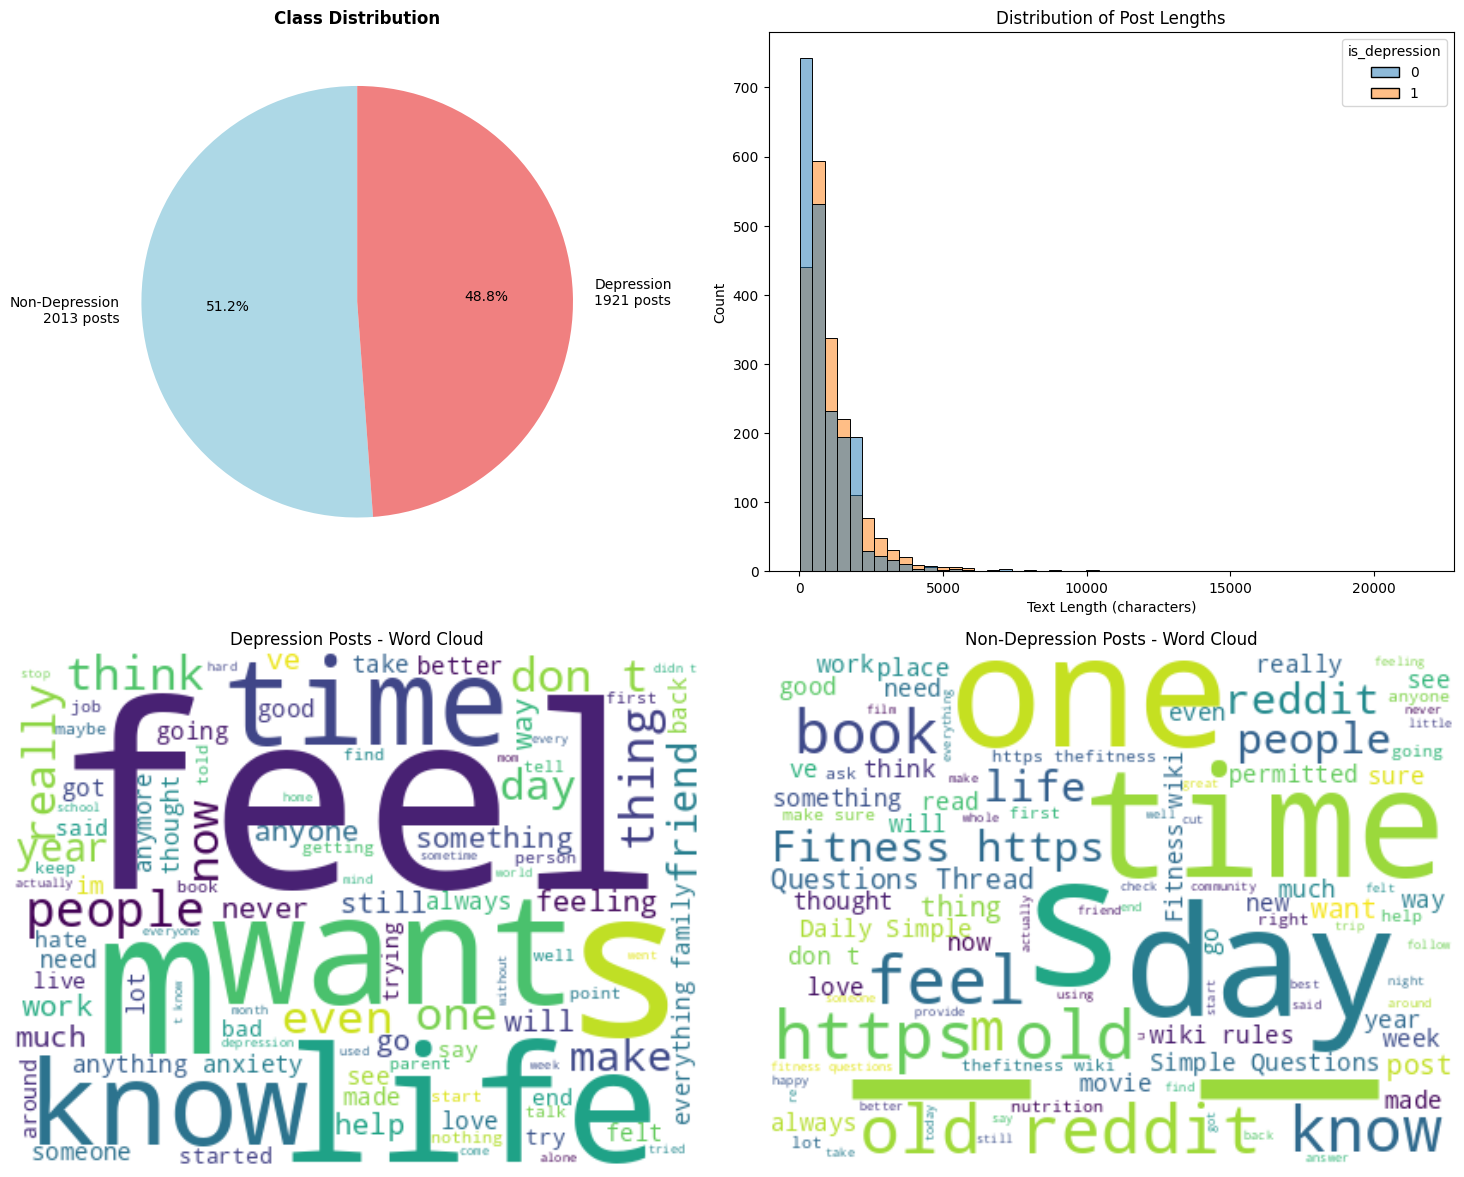


 Subreddit Analysis:
subreddit
selfimprovement       300
depression            298
SuicideWatch          298
fitness               298
CasualConversation    298
travel                298
mentalhealth          297
Anxiety               295
CPTSD                 294
gardening             243
Name: count, dtype: int64


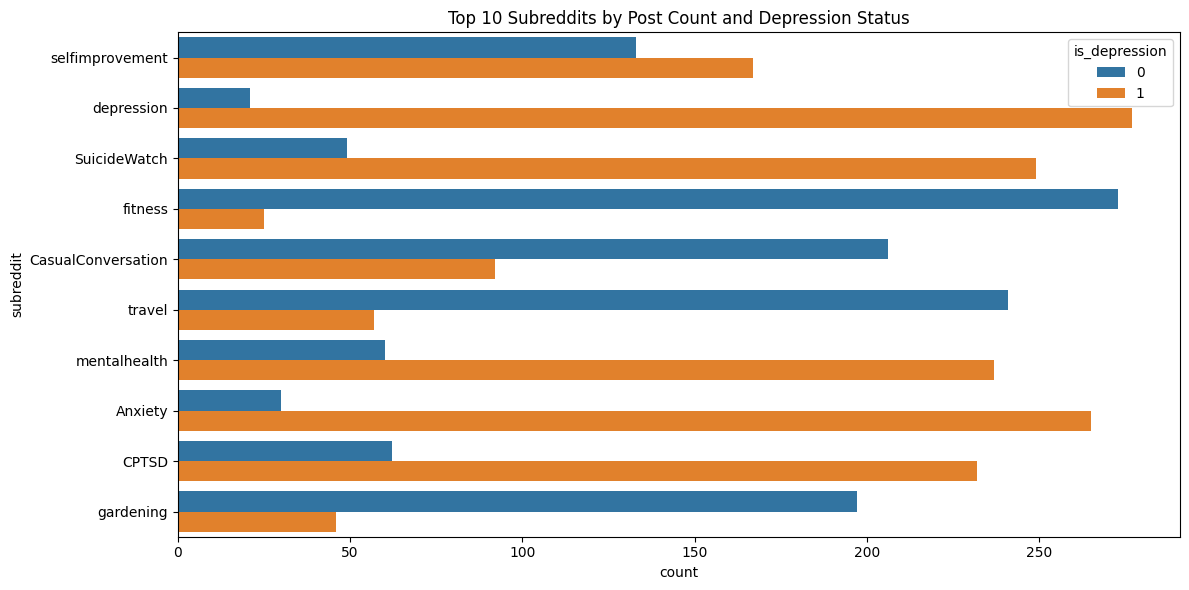


 Training Depression Detection Model...
 spaCy model loaded successfully!
 Depression Detection Model Initialized!
   Available models: Logistic Regression, Random Forest, SVM
 Preprocessing texts and extracting features...
   Processed 0/3934 texts...
   Processed 100/3934 texts...
   Processed 200/3934 texts...
   Processed 300/3934 texts...
   Processed 400/3934 texts...
   Processed 500/3934 texts...
   Processed 600/3934 texts...
   Processed 700/3934 texts...
   Processed 800/3934 texts...
   Processed 900/3934 texts...
   Processed 1000/3934 texts...
   Processed 1100/3934 texts...
   Processed 1200/3934 texts...
   Processed 1300/3934 texts...
   Processed 1400/3934 texts...
   Processed 1500/3934 texts...
   Processed 1600/3934 texts...
   Processed 1700/3934 texts...
   Processed 1800/3934 texts...
   Processed 1900/3934 texts...
   Processed 2000/3934 texts...
   Processed 2100/3934 texts...
   Processed 2200/3934 texts...
   Processed 2300/3934 texts...
   Processed 2400/3

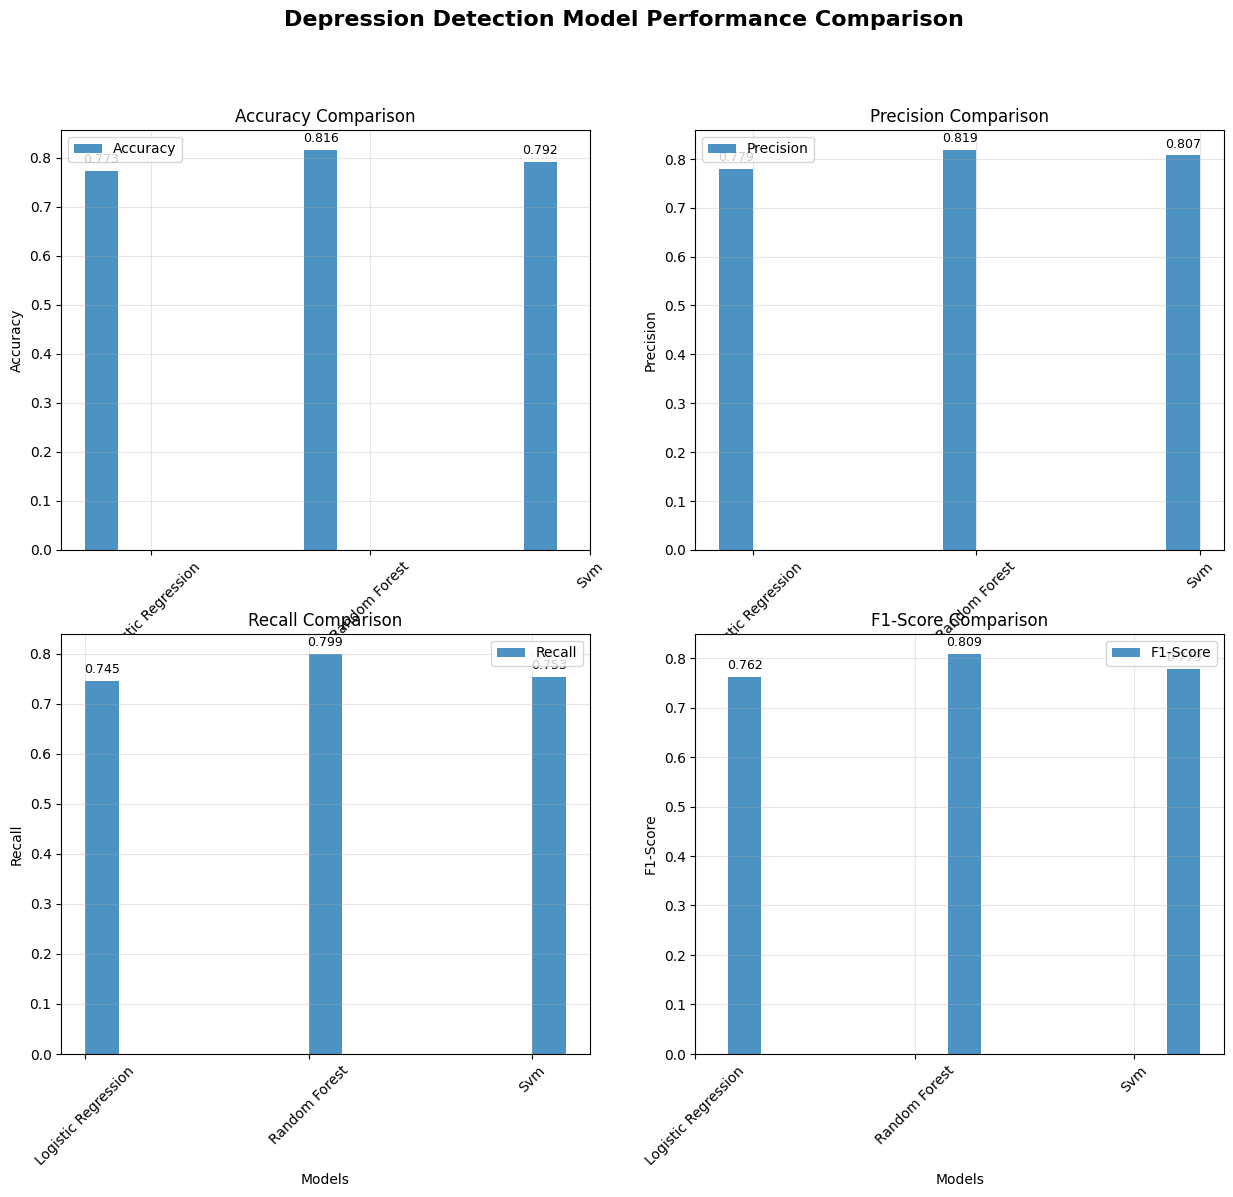

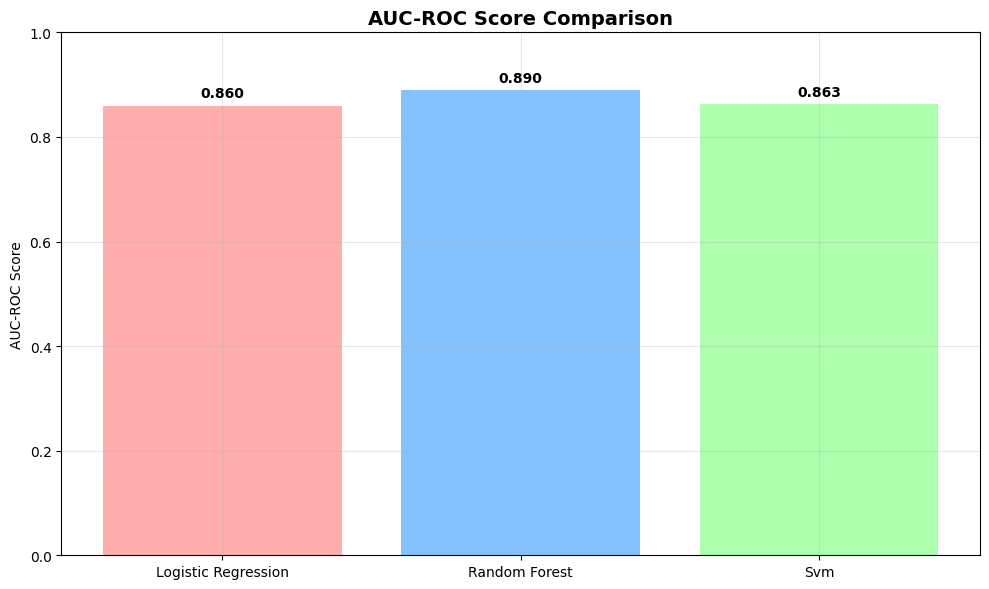

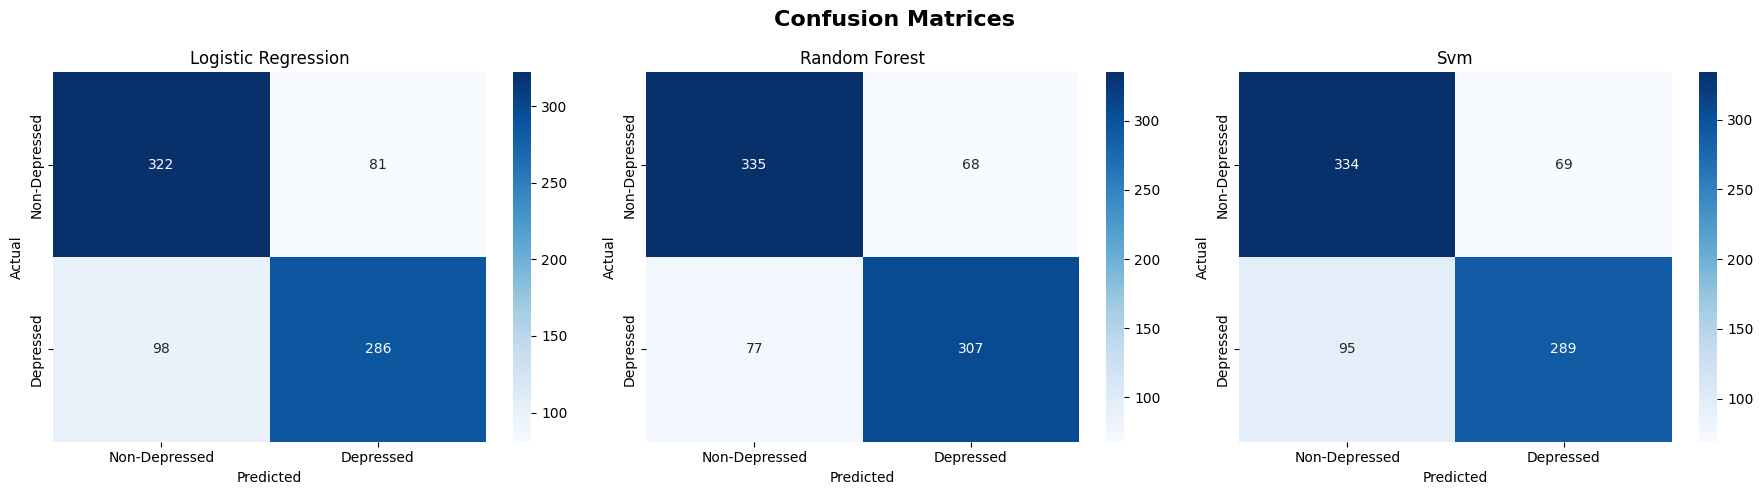


 Analyzing Important Features...

🔍 Top 20 Most Important Features for Depression Detection:
   first_person_singular: 0.0757
   emotional_words: 0.0694
   avg_word_len: 0.0314
   anxiety: 0.0197
   negation: 0.0179
   life: 0.0153
   want: 0.0144
   word_count: 0.0109
   second_person: 0.0109
   hate: 0.0103
   anymore: 0.0101
   thread: 0.0094
   sentence_count: 0.0088
   worse: 0.0082
   feel: 0.0073
   questions: 0.0071
   scared: 0.0070
   past_tense: 0.0066
   first_person_plural: 0.0065
   fuck: 0.0064


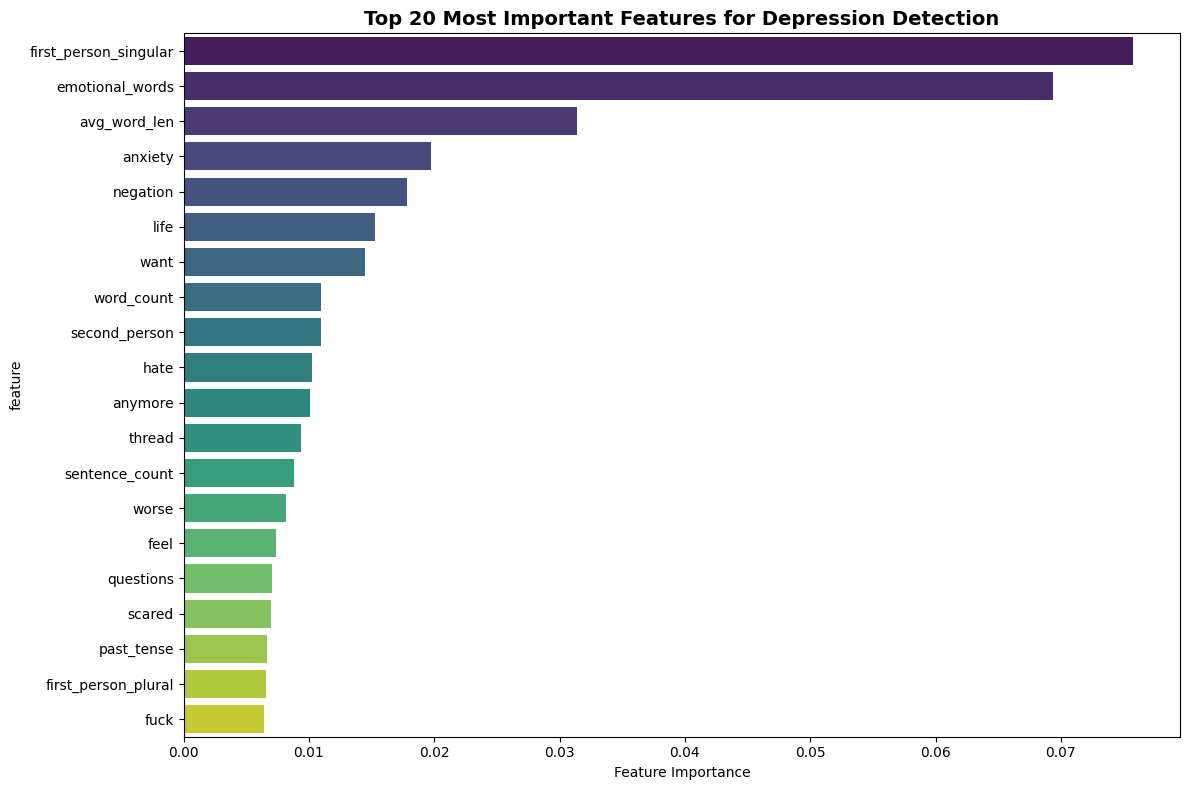


 Key Linguistic Features in Top 20:
   first_person_singular: 0.0757
   emotional_words: 0.0694
   negation: 0.0179
   word_count: 0.0109
   past_tense: 0.0066

 Testing with Sample Texts from Dataset...

Depression Sample:
Text: 'Fortunately, there's still death. Fortunately, I know that no matter what happens, nothing lasts for...'
  Random Forest: Depression probability: 0.750
  Key Linguistic Features:
    First person singular: 0.068
    Past tense ratio: 0.154
    Negation ratio: 0.041
    Emotional words: 0.055

Depression Sample:
Text: 'The misogyny of the world is making me depressed I cant stand it. Everyday feels like pulling teeth....'
  Random Forest: Depression probability: 0.765
  Key Linguistic Features:
    First person singular: 0.122
    Past tense ratio: 0.000
    Negation ratio: 0.000
    Emotional words: 0.073

Non-Depression Sample:
Text: 'Depression advice often requires one to not be depressed. why is all depression advice effectively:
...'
  Random Forest: De

In [9]:
# File Upload and Execution Cell
from google.colab import files
import io

def upload_and_process():
    """
    Upload CSV file and process it
    """
    print(" Upload your CSV file...")
    uploaded = files.upload()

    if uploaded:
        file_name = list(uploaded.keys())[0]
        print(f" File '{file_name}' uploaded successfully!")

        # Read the uploaded file
        df = pd.read_csv(io.BytesIO(uploaded[file_name]))

        # Run the main pipeline
        return main(file_name)
    else:
        print(" No file uploaded.")
        return None, None, None

# Choose one of the following options:

# Option 1: If your file is already in Colab, use this:
# csv_file_path = "/content/your_depression_data.csv"  # Change to your file path
# model, results, data = main(csv_file_path)

# Option 2: To upload file interactively, uncomment the line below:
# model, results, data = upload_and_process()

print(" Instructions:")
print("1. Upload your CSV file to Colab using the files panel on the left")
print("2. Update the csv_file_path variable with your actual file path")
print("3. Run the main function with your file path")
print("4. Or use the upload_and_process() function for interactive upload")

# Example with a sample file path (replace with your actual path)
# Uncomment and modify the line below:
model, results, data = main("/content/reddit_labeled_by_pretrained (2).csv")

In [11]:
# Standalone Custom Testing Block
# Run this cell after training to test on custom texts

def test_custom_texts(trained_model, test_texts=None):
    """
    Test custom texts on the trained model
    This works independently of the main pipeline
    """
    print(" CUSTOM TEXT TESTING")
    print("=" * 60)

    # Default test texts if none provided
    if test_texts is None:
        test_texts = [
            "I just feel so empty inside and don't know how to keep going anymore",
            "Had a wonderful day with my family, feeling blessed and happy",
            "Everything seems pointless and I can't find joy in anything I do",
            "Just finished a great book and planning my next vacation!"
        ]

    print(f"Testing {len(test_texts)} custom texts...\n")

    results = []

    for i, text in enumerate(test_texts, 1):
        print(f" Text {i}: '{text}'")

        # Get prediction using the trained model
        prediction_result = trained_model.predict_single_text(text)

        # Extract Random Forest prediction (most reliable)
        rf_pred = prediction_result['predictions']['random_forest']
        probability = rf_pred['probability']
        prediction_class = rf_pred['prediction']

        # Determine status
        status = "DEPRESSED" if prediction_class == 1 else "NOT DEPRESSED"

        print(f"    Prediction: {status}")
        print(f"    Probability: {probability:.3f}")

        # Show confidence level
        if probability > 0.7:
            confidence_level = "HIGH"
        elif probability > 0.6:
            confidence_level = "MEDIUM"
        else:
            confidence_level = "LOW"

        print(f"    Confidence: {confidence_level}")

        # Quick linguistic insights
        ling_features = prediction_result['linguistic_features']
        print(f"    Key Indicators:")
        print(f"      - First person usage: {ling_features['first_person_singular_ratio']:.3f}")
        print(f"      - Negation density: {ling_features['negation_ratio']:.3f}")
        print(f"      - Emotional words: {ling_features['emotional_word_ratio']:.3f}")

        print("-" * 50)

        results.append({
            'text': text,
            'probability': probability,
            'prediction': prediction_class,
            'status': status,
            'confidence': confidence_level
        })

    # Summary
    print("\n TESTING SUMMARY")
    print("=" * 50)

    depressed_count = sum(1 for r in results if r['prediction'] == 1)
    avg_probability = np.mean([r['probability'] for r in results])

    print(f"Total texts tested: {len(results)}")
    print(f"Depression detected in: {depressed_count} texts")
    print(f"Average probability score: {avg_probability:.3f}")

    return results

# Example usage with the trained model:

test_texts = [
     "I just feel so empty inside and don't know how to keep going anymore",
     "Had a wonderful day with my family, feeling blessed and happy",
     "Everything seems pointless and I can't find joy in anything I do",
     "Just finished a great book and planning my next vacation!",
     "Sometimes I wonder if anyone would care if I disappeared",
     "Excited about my new job opportunity starting next month"]

results = test_custom_texts(model, test_texts)

 CUSTOM TEXT TESTING
Testing 6 custom texts...

 Text 1: 'I just feel so empty inside and don't know how to keep going anymore'
    Prediction: DEPRESSED
    Probability: 0.551
    Confidence: LOW
    Key Indicators:
      - First person usage: 0.067
      - Negation density: 0.000
      - Emotional words: 0.067
--------------------------------------------------
 Text 2: 'Had a wonderful day with my family, feeling blessed and happy'
    Prediction: NOT DEPRESSED
    Probability: 0.323
    Confidence: LOW
    Key Indicators:
      - First person usage: 0.091
      - Negation density: 0.000
      - Emotional words: 0.000
--------------------------------------------------
 Text 3: 'Everything seems pointless and I can't find joy in anything I do'
    Prediction: NOT DEPRESSED
    Probability: 0.384
    Confidence: LOW
    Key Indicators:
      - First person usage: 0.154
      - Negation density: 0.000
      - Emotional words: 0.000
--------------------------------------------------
 Tex

In [12]:
import pandas as pd
import numpy as np

# Interactive Testing Block
# Run this cell to test any text interactively

def interactive_testing(trained_model):
    """
    Interactive testing - enter texts one by one and get predictions
    """
    print(" INTERACTIVE TEXT TESTING")
    print("=" * 60)
    print("Enter texts to analyze (type 'quit' to stop):\n")

    test_count = 0
    all_results = []

    while True:
        # Get user input
        user_text = input("Enter text to analyze: ").strip()

        # Check for exit condition
        if user_text.lower() in ['quit', 'exit', 'stop', '']:
            break

        if len(user_text) < 5:
            print("Text too short. Please enter at least 5 characters.\n")
            continue

        test_count += 1
        print(f"\n Analyzing text {test_count}...")

        # Get prediction
        try:
            prediction_result = trained_model.predict_single_text(user_text)
            rf_pred = prediction_result['predictions']['random_forest']

            probability = rf_pred['probability']
            status = "DEPRESSED" if rf_pred['prediction'] == 1 else "NOT DEPRESSED"

            # Display results
            print(f" RESULTS:")
            print(f"   Prediction: {status}")
            print(f"   Probability: {probability:.3f}")

            # Color-coded output based on probability
            if probability > 0.7:
                print("    HIGH depression risk detected")
            elif probability > 0.6:
                print("     MODERATE depression risk detected")
            elif probability > 0.4:
                print("    LOW depression risk detected")
            else:
                print("    Very low depression risk")

            # Quick insights
            ling = prediction_result['linguistic_features']
            print(f"   Key insights:")
            if ling['first_person_singular_ratio'] > 0.08:
                print(f"      - High self-reference (I, me, my)")
            if ling['negation_ratio'] > 0.03:
                print(f"      - Frequent negative language")
            if ling['emotional_word_ratio'] > 0.02:
                print(f"      - Emotional vocabulary present")

            # Store results
            all_results.append({
                'text': user_text,
                'probability': probability,
                'status': status
            })

        except Exception as e:
            print(f" Error analyzing text: {e}")

        print("-" * 50 + "\n")

    # Session summary
    if all_results:
        print("\n SESSION SUMMARY")
        print("=" * 50)
        print(f"Total texts analyzed: {len(all_results)}")

        high_risk = sum(1 for r in all_results if r['probability'] > 0.7)
        avg_prob = np.mean([r['probability'] for r in all_results])

        print(f"High-risk texts: {high_risk}")
        print(f"Average probability: {avg_prob:.3f}")

        if high_risk > 0:
            print("\n  High-risk texts detected. Consider professional support.")

    return all_results

# Uncomment to run interactive testing:
interactive_testing(model)

 INTERACTIVE TEXT TESTING
Enter texts to analyze (type 'quit' to stop):

Enter text to analyze:  Lately I can’t find the energy to get out of bed. Everything feels pointless no matter how hard I try

 Analyzing text 1...
 RESULTS:
   Prediction: DEPRESSED
   Probability: 0.602
     MODERATE depression risk detected
   Key insights:
      - High self-reference (I, me, my)
      - Frequent negative language
--------------------------------------------------

Enter text to analyze: I don’t think anyone would really notice if I just disappeared for a while

 Analyzing text 2...
 RESULTS:
   Prediction: NOT DEPRESSED
   Probability: 0.380
    Very low depression risk
   Key insights:
      - High self-reference (I, me, my)
--------------------------------------------------

Enter text to analyze: Just finished a long day at work. Gonna watch some Netflix and relax.

 Analyzing text 3...
 RESULTS:
   Prediction: NOT DEPRESSED
   Probability: 0.290
    Very low depression risk
   Key insights

[{'text': 'Lately I can’t find the energy to get out of bed. Everything feels pointless no matter how hard I try',
  'probability': np.float64(0.6024365940285467),
  'status': 'DEPRESSED'},
 {'text': 'I don’t think anyone would really notice if I just disappeared for a while',
  'probability': np.float64(0.37979696197357815),
  'status': 'NOT DEPRESSED'},
 {'text': 'Just finished a long day at work. Gonna watch some Netflix and relax.',
  'probability': np.float64(0.2895197781406645),
  'status': 'NOT DEPRESSED'},
 {'text': 'feel like I’m drowning in my own thoughts and no one can hear me calling for help.',
  'probability': np.float64(0.5530453960913916),
  'status': 'DEPRESSED'},
 {'text': 'I’m finally starting to feel confident about my future and the goals I’ve set for myself',
  'probability': np.float64(0.36456851178044347),
  'status': 'NOT DEPRESSED'},
 {'text': 'I’m surrounded by people, but I still feel completely alone.',
  'probability': np.float64(0.3475368817088134),
  's